# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

## Problema de negócio

## Extração dos dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração será realizada utilizando SQL utilizando a API do **BigQuery**.

In [11]:
# Consulta

import os
import pandas as pd
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

client = bigquery.Client()

query = """
        SELECT sigla_uf, situacao_domicilio, v0202 AS tipo_domicilio, v0205 AS condicao_domicilio, v0203 AS comodos, v0204 AS dormitorios,v0209 AS banheiros, v0207 AS agua, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v7100 as iluminacao_publica, v0212 AS coleta_lixo, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres, v7616 AS rendimento
        FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
        WHERE (v7616 IS NOT NULL) AND (v7616 > 0) AND v0201 = 1
        ORDER BY RAND() 
        LIMIT 100000;
        """

df_raw = client.query(query).to_dataframe()
df_raw.to_csv('data/df_raw.csv', index=False)

df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
0,PE,1,1,3,3,1,1,1,1,1,...,2,1,0,0,3,1,3,1,2,100
1,MG,1,1,3,6,3,1,1,1,2,...,2,1,0,0,5,1,5,3,2,461
2,RS,2,1,1,4,1,0,2,1,1,...,2,1,0,0,2,3,2,1,1,80
3,SP,1,1,1,13,3,2,1,1,1,...,2,2,1,0,4,1,4,1,3,1000
4,MG,1,1,1,3,1,1,1,1,1,...,2,1,0,0,5,1,5,3,2,600


## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
id_municipio |str    | ID de 7 dígitos do IBGE
situacao_domicilio | int64 |

In [1]:
# sigla_uf	STRING	Sigla da Unidade da Federação
# id_municipio	STRING	ID Município - IBGE 7 Dígitos
# situacao_domicilio	INT64	Situação do domicílio
# v0110	INT64	Total de homens
# v0111	INT64	Total de mulheres
# v0202	INT64	Tipo do domicílio
# v0203	INT64	Total de cômodos
# v0205	INT64	Condição do domicílio
# v0207	INT64	Forma de abastecimento de água
# v0209	INT64	Total de banheiros
# v0212	INT64	Coleta de lixo
# v0213	INT64	Iluminação elétrica
# v0214	INT64	Existência de rádio
# v0215	INT64	Existência de geladeira ou freezer
# v0216	INT64	Existência de videocassete
# v0217	INT64	Existência de máquina de lavar roupa
# v0218	INT64	Existência de forno de microondas
# v0219	INT64	Existência de linha telefônica instalada
# v0220	INT64	Existência de microcomputador
# v0221	INT64	Quantidade existente de televisores
# v0222	INT64	Quantidade existente de automóveis para uso particular
# v0223	INT64	Quantidade existente de aparelhos de ar condicionado
# v7100	INT64	Total de moradores no domicílio
# v1112	INT64	Existência de iluminação pública
# v1113	INT64	Existência de calçamento/pavimentação

# v7616	INT64	Total de rendimentos do domicílio particular

## Explorando os dados

In [12]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [13]:
df_raw = pd.read_csv('data/df_raw.csv')

In [14]:
df_raw.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
0,PE,1,1,3,3,1,1,1,1,1,...,2,1,0,0,3,1,3,1,2,100
1,MG,1,1,3,6,3,1,1,1,2,...,2,1,0,0,5,1,5,3,2,461
2,RS,2,1,1,4,1,0,2,1,1,...,2,1,0,0,2,3,2,1,1,80
3,SP,1,1,1,13,3,2,1,1,1,...,2,2,1,0,4,1,4,1,3,1000
4,MG,1,1,1,3,1,1,1,1,1,...,2,1,0,0,5,1,5,3,2,600


In [15]:
df_raw.shape

(100000, 25)

In [16]:
df_raw.isna().sum()

sigla_uf              0
situacao_domicilio    0
tipo_domicilio        0
condicao_domicilio    0
comodos               0
dormitorios           0
banheiros             0
agua                  0
iluminacao            0
radio                 0
geladeira             0
videocassete          0
maquina_lavar         0
microondas            0
telefone              0
computador            0
televisores           0
automoveis            0
ar_condicionado       0
iluminacao_publica    0
coleta_lixo           0
moradores             0
homens                0
mulheres              0
rendimento            0
dtype: int64

In [18]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sigla_uf            100000 non-null  object
 1   situacao_domicilio  100000 non-null  int64 
 2   tipo_domicilio      100000 non-null  int64 
 3   condicao_domicilio  100000 non-null  int64 
 4   comodos             100000 non-null  int64 
 5   dormitorios         100000 non-null  int64 
 6   banheiros           100000 non-null  int64 
 7   agua                100000 non-null  int64 
 8   iluminacao          100000 non-null  int64 
 9   radio               100000 non-null  int64 
 10  geladeira           100000 non-null  int64 
 11  videocassete        100000 non-null  int64 
 12  maquina_lavar       100000 non-null  int64 
 13  microondas          100000 non-null  int64 
 14  telefone            100000 non-null  int64 
 15  computador          100000 non-null  int64 
 16  tel

In [20]:
df_raw.describe()

,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.200640,1.106990,1.754530,5.72113,2.026210,1.10044,1.316170,1.060030,1.123300,1.173800,...,1.902120,1.28697,0.400970,0.106140,3.848550,1.767300,3.848550,1.899190,1.949360,1097.617430
std,0.400481,0.341679,1.279512,2.36799,0.870029,0.81956,0.594365,0.237544,0.328783,0.378939,...,0.297154,0.89273,0.649013,0.466151,1.957603,1.400825,1.957603,1.272188,1.219496,2602.635795
min,1.000000,1.000000,1.000000,1.00000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000
25%,1.000000,1.000000,1.000000,4.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.00000,0.000000,0.000000,3.000000,1.000000,3.000000,1.000000,1.000000,290.000000
50%,1.000000,1.000000,1.000000,5.00000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.00000,0.000000,0.000000,4.000000,1.000000,4.000000,2.000000,2.000000,515.000000
75%,1.000000,1.000000,2.000000,7.00000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.00000,1.000000,0.000000,5.000000,2.000000,5.000000,3.000000,3.000000,1100.000000
max,2.000000,3.000000,6.000000,30.00000,9.000000,9.00000,3.000000,2.000000,2.000000,2.000000,...,2.000000,9.00000,7.000000,9.000000,31.000000,7.000000,31.000000,13.000000,18.000000,300000.000000


## Pre-processamento

In [22]:
df = df_raw.copy()

In [23]:
df['situacao_domicilio'] = df_raw['situacao_domicilio'].map({1:'urbano', 2:'rural'})

In [24]:
df['tipo_domicilio'] = df_raw['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})

In [25]:
df['condicao_domicilio'] = df_raw['condicao_domicilio'].map({1:'proprio pago',
                                                             2:'proprio pagando',
                                                             3:'alugado',
                                                             4:'cedido por empregador.',
                                                             5:'cedido',
                                                             6:'outro'})

In [26]:
df.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
0,PE,urbano,casa,alugado,3,1,1,1,1,1,...,2,1,0,0,3,1,3,1,2,100
1,MG,urbano,casa,alugado,6,3,1,1,1,2,...,2,1,0,0,5,1,5,3,2,461
2,RS,rural,casa,proprio pago,4,1,0,2,1,1,...,2,1,0,0,2,3,2,1,1,80
3,SP,urbano,casa,proprio pago,13,3,2,1,1,1,...,2,2,1,0,4,1,4,1,3,1000
4,MG,urbano,casa,proprio pago,3,1,1,1,1,1,...,2,1,0,0,5,1,5,3,2,600


In [27]:
# Train-Test Split

X = df.drop('rendimento', axis=1)
y = df['rendimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print(f'train: {y_train.shape[0]}, test: {y_test.shape[0]}')

train: 80000, test: 20000


## EDA

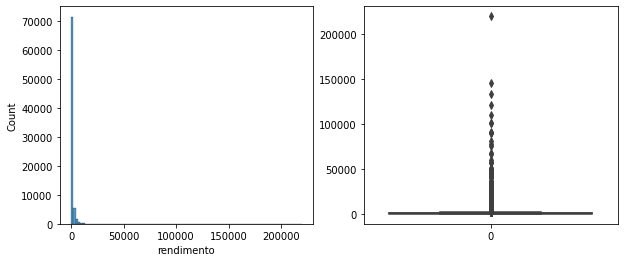

In [45]:
# O target é extremamente assimétrico

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(y_train, bins=100)

plt.subplot(1,2,2)
sns.boxplot(data=y_train)

plt.show()

In [46]:
y_train.describe()

count     80000.000000
mean       1102.007275
std        2500.910252
min           5.000000
25%         290.000000
50%         515.000000
75%        1100.000000
max      219600.000000
Name: rendimento, dtype: float64

In [65]:
# Considerar no próximo ciclo treinar sem os dados extremos

np.percentile(y_train, 1)
np.percentile(y_train, 99)
(y_train < 50).sum()
(y_train > 9000).sum()

815

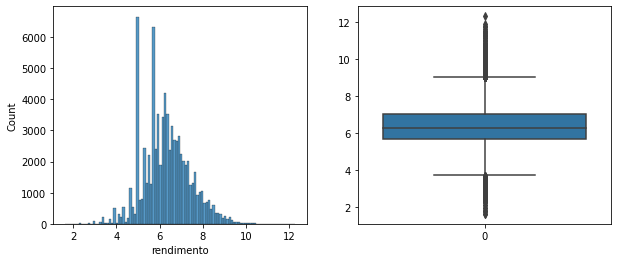

In [66]:
# Fazendo uma log transformation

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(np.log(y_train), bins=100)

plt.subplot(1,2,2)
sns.boxplot(data=np.log(y_train))

plt.show()

In [9]:
X_train.head()

,sigla_uf,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,...,videocassete,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao
4576,RS,1,8.0,1.0,1.0,6,4,2,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,6,3.0
1088,SP,1,4.0,2.0,1.0,5,1,4,1.0,1.0,...,2.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,5,1.0
479,SP,1,5.0,1.0,2.0,4,1,3,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,4,1.0
727,SP,1,4.0,2.0,1.0,3,2,1,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,3,1.0
3783,RS,1,5.0,1.0,1.0,1,0,1,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1,1.0


### sigla_uf

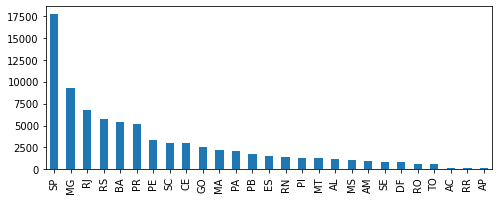

In [74]:
plt.figure(figsize=(8,3))
X_train['sigla_uf'].value_counts().plot(kind='bar')
plt.show()

In [94]:
# Plotar mapa com renda

# !pip3 install geopandas geobr descartes

import geopandas as gpd
import geobr

# Checa lista de atributos

geobr.list_geobr()

Function: read_country
Geographies available: Country
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_region
Geographies available: Region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_state
Geographies available: States
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_meso_region
Geographies available: Meso region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_micro_region
Geographies available: Micro region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

/home/franklin/.local/lib/python3.8/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/franklin/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


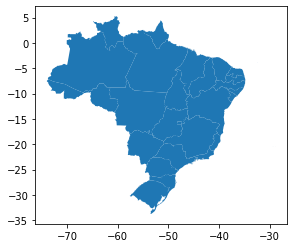

In [95]:
# Plot dos estados
estados = geobr.read_state(year=2000)
estados.plot()
plt.show()

In [103]:
X_train.join(y_train)

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
75220,PR,urbano,casa,proprio pago,9,3,2,1,1,1,...,1,2,1,0,5,1,5,3,2,2400
48955,DF,urbano,casa,alugado,5,2,1,1,1,1,...,2,2,0,0,5,1,5,1,4,2032
44966,SP,urbano,casa,alugado,4,1,1,1,1,1,...,2,1,0,0,3,1,3,2,1,400
13568,RS,urbano,casa,proprio pago,10,2,2,1,1,1,...,2,2,1,0,3,1,3,1,2,2300
92727,SC,urbano,casa,proprio pago,9,4,2,1,1,1,...,2,1,2,0,4,2,4,2,2,10500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,SP,urbano,casa,alugado,6,2,1,1,1,1,...,1,1,0,0,2,2,2,2,0,3300
54886,RJ,urbano,casa,proprio pago,7,3,2,1,1,1,...,2,2,0,0,8,1,8,4,4,701
76820,ES,rural,casa,proprio pago,7,3,1,2,1,1,...,2,0,0,0,5,3,5,2,3,5200
860,SP,urbano,apartamento,proprio pago,6,2,1,1,1,1,...,2,2,0,0,3,1,3,2,1,1380


In [112]:
X_train.join(y_train)[['sigla_uf', 'rendimento']].groupby('sigla_uf').median().sort_values(by='rendimento', ascending=False)

,rendimento
sigla_uf,
DF,1001.0
SP,830.0
RJ,752.0
SC,690.0
RS,600.0
PR,551.0
AP,550.0
ES,531.5
MT,518.5


### situacao_domicilio

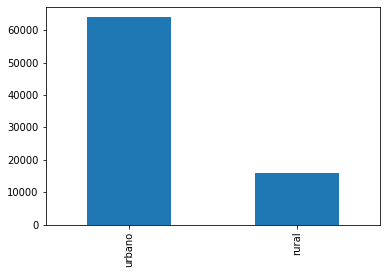

In [99]:
X_train['situacao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [118]:
X_train.join(y_train).groupby('situacao_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,videocassete,maquina_lavar,microondas,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
situacao_domicilio,,,,,,,,,,,,,,,,,,,,,
urbano,5.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,1.0,4.0,2.0,2.0,602.0
rural,5.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,3.0,4.0,2.0,2.0,301.0


### condicao_domicilio

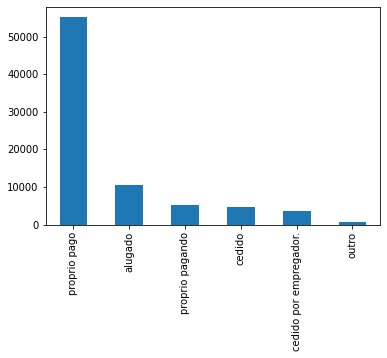

In [123]:
X_train['condicao_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [122]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres
75220,PR,urbano,casa,proprio pago,9,3,2,1,1,1,...,1,1,2,1,0,5,1,5,3,2
48955,DF,urbano,casa,alugado,5,2,1,1,1,1,...,1,2,2,0,0,5,1,5,1,4
44966,SP,urbano,casa,alugado,4,1,1,1,1,1,...,1,2,1,0,0,3,1,3,2,1
13568,RS,urbano,casa,proprio pago,10,2,2,1,1,1,...,1,2,2,1,0,3,1,3,1,2
92727,SC,urbano,casa,proprio pago,9,4,2,1,1,1,...,1,2,1,2,0,4,2,4,2,2


### tipo_domicilio

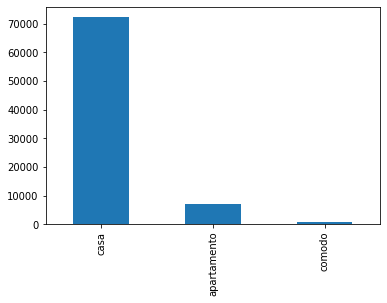

In [116]:
X_train['tipo_domicilio'].value_counts().plot(kind='bar')
plt.show()

In [117]:
X_train.join(y_train).groupby('tipo_domicilio').median().sort_values(by='rendimento', ascending=False)

,comodos,dormitorios,banheiros,agua,iluminacao,radio,geladeira,videocassete,maquina_lavar,microondas,...,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres,rendimento
tipo_domicilio,,,,,,,,,,,,,,,,,,,,,
apartamento,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,0.0,3.0,1.0,3.0,1.0,1.0,1773.0
casa,5.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,4.0,1.0,4.0,2.0,2.0,491.0
comodo,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,300.0


### comodos

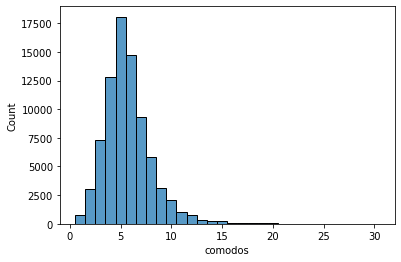

In [125]:
sns.histplot(data=X_train, x='comodos', discrete=True);

In [126]:
X_train['comodos'].describe()

count    80000.000000
mean         5.725937
std          2.375110
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         30.000000
Name: comodos, dtype: float64

## Correlações

rendimento            1.000000
banheiros             0.421716
automoveis            0.417494
televisores           0.365416
comodos               0.350612
ar_condicionado       0.299551
dormitorios           0.155233
iluminacao_publica    0.012103
moradores             0.012103
mulheres              0.011340
homens                0.007764
iluminacao           -0.082308
radio                -0.092194
agua                 -0.119681
coleta_lixo          -0.138593
geladeira            -0.148135
maquina_lavar        -0.290742
videocassete         -0.295755
telefone             -0.297586
microondas           -0.328468
computador           -0.357760
Name: rendimento, dtype: float64


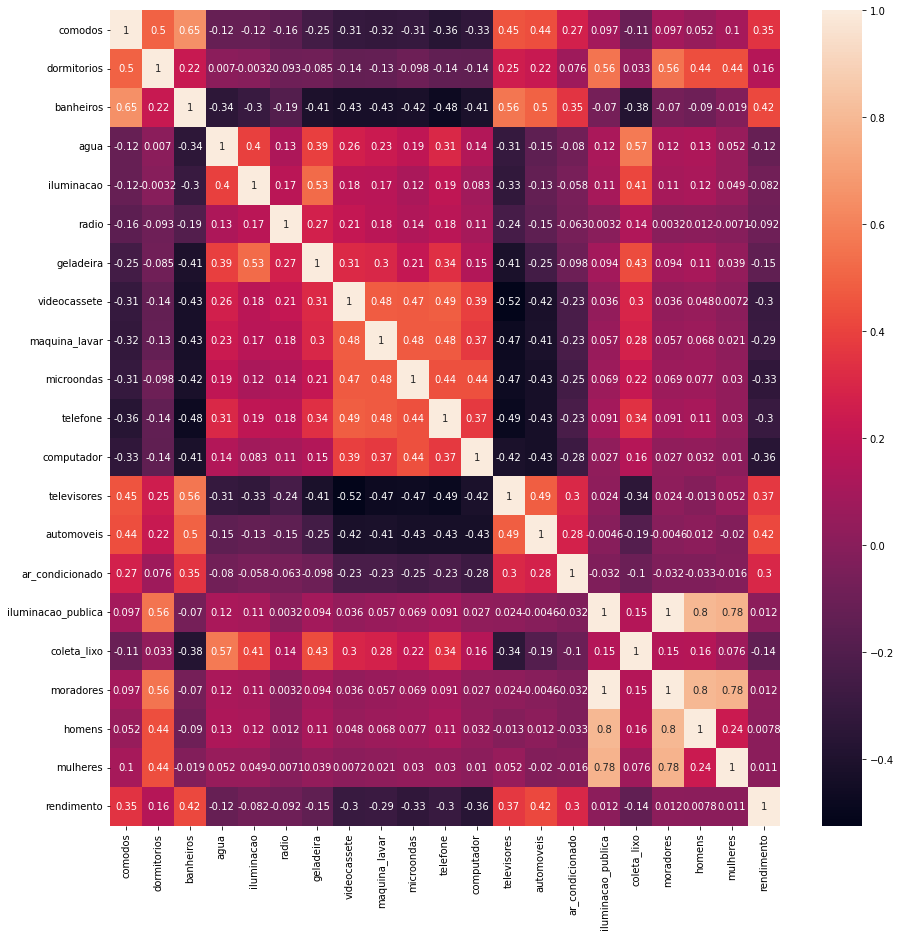

In [127]:
corr = X_train.join(y_train).corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True);

print(corr['rendimento'].sort_values(ascending=False))

## Modelos de ML

In [128]:
X_train.head()

,sigla_uf,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,dormitorios,banheiros,agua,iluminacao,radio,...,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,coleta_lixo,moradores,homens,mulheres
75220,PR,urbano,casa,proprio pago,9,3,2,1,1,1,...,1,1,2,1,0,5,1,5,3,2
48955,DF,urbano,casa,alugado,5,2,1,1,1,1,...,1,2,2,0,0,5,1,5,1,4
44966,SP,urbano,casa,alugado,4,1,1,1,1,1,...,1,2,1,0,0,3,1,3,2,1
13568,RS,urbano,casa,proprio pago,10,2,2,1,1,1,...,1,2,2,1,0,3,1,3,1,2
92727,SC,urbano,casa,proprio pago,9,4,2,1,1,1,...,1,2,1,2,0,4,2,4,2,2


In [130]:
# Tratamento

ohe = OneHotEncoder(drop='first')
ohe_ct = ColumnTransformer(transformers=[('ohe', ohe, [0,1,2,3])], remainder='passthrough')
std_scaler = StandardScaler()
tr_pipeline = Pipeline([('ohe_ct', ohe_ct), ('scale', std_scaler)])

tr_pipeline

Pipeline(steps=[('ohe_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  [0, 1, 2, 3])])),
                ('scale', StandardScaler())])

In [133]:
X_train_tr = tr_pipeline.fit_transform(X_train)
X_test_tr = tr_pipeline.transform(X_test)

In [135]:
X_train_tr.shape

(80000, 54)

In [134]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_tr, y_train)
y_pred = forest_reg.predict(X_test_tr)

np.sqrt(mean_squared_error(y_test, y_pred))

2684.65740153549

In [136]:
# Evaluating

lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)
y_pred = lin_reg.predict(X_test_tr)

print(f'R2: {r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

R2: 0.21846424420817256
RMSE: 2629.9332652118105
